In [32]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# The dataset link: https://www.kaggle.com/datasets/globalmediadata/socialmediausage-sleepdata-sg

In [33]:
df = pd.read_csv('SocialMediaUsage_SleepLatencyAnalysis_Singapore.csv', encoding='utf-8')

# Knowing The Data

In [34]:
print(df.shape)

(500, 20)


In [35]:
df.head()

,Participant ID,Age,Gender,Chronotype,Average Daily Social Media Use Time (minutes),Dominant Social Media Platform,Frequency of Social Media Checking (number of times per day),Pre-Sleep Social Media Use Duration (minutes),Type of Social Media Content Consumed,Sleep Latency (minutes),Total Sleep Time (hours),Sleep Efficiency (%),Sleep Quality Rating,Wake After Sleep Onset (WASO) (minutes),Number of Awakenings (during sleep),Melatonin Level (pg/mL),Cortisol Level (pg/mL),Day of Week,Blue Light Exposure Before Sleep (minutes),Stress Level Rating
0,1,56,Other,Evening Owl,123.661212,Instagram,20,72.650150,Social Interaction,20.961023,4.953115,84.919279,3.369066,28.454612,3,27.475901,111.611989,Friday,47.683296,3.802238
1,2,46,Female,Neither,68.877915,Instagram,40,40.096685,News,19.012622,6.466231,84.647120,4.544391,18.160790,2,34.136387,123.477195,Friday,22.171777,2.768907
2,3,32,Male,Neither,143.799199,TikTok,29,58.147004,News,20.481638,5.204305,78.259513,1.506376,29.832344,3,17.813907,98.024130,Friday,29.615623,4.704535
3,4,60,Other,Evening Owl,213.318626,Twitter,5,51.842214,Social Interaction,29.892398,3.760281,74.195231,1.000000,37.331240,5,13.455934,131.011318,Thursday,46.778311,5.000000
4,5,25,Female,Evening Owl,183.767226,Twitter,39,81.919265,Entertainment,28.905470,5.186388,81.763091,1.186496,22.922240,4,16.317120,117.268808,Thursday,46.607758,5.000000


In [36]:
df.describe()

,Participant ID,Age,Average Daily Social Media Use Time (minutes),Frequency of Social Media Checking (number of times per day),Pre-Sleep Social Media Use Duration (minutes),Sleep Latency (minutes),Total Sleep Time (hours),Sleep Efficiency (%),Sleep Quality Rating,Wake After Sleep Onset (WASO) (minutes),Number of Awakenings (during sleep),Melatonin Level (pg/mL),Cortisol Level (pg/mL),Blue Light Exposure Before Sleep (minutes),Stress Level Rating
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,41.980000,138.511928,26.808000,68.774225,23.765558,5.240398,81.177902,2.341209,23.867780,3.222000,22.532367,113.505904,51.834984,3.647550
std,144.481833,13.800598,62.329189,12.824354,40.142413,7.954742,1.324331,6.576889,1.193130,8.191032,1.366914,12.770327,12.337649,33.103691,1.197424
min,1.000000,18.000000,31.037396,5.000000,6.692946,5.000000,3.000000,67.040582,1.000000,0.776081,0.000000,5.000000,84.260116,4.021635,1.000000
25%,125.750000,31.000000,80.657890,16.000000,36.980603,18.266476,4.136356,75.531255,1.068380,18.043526,2.000000,11.472222,104.861103,25.991967,2.710984
50%,250.500000,43.000000,143.028900,27.000000,61.264379,24.191395,5.190124,80.802759,2.146824,23.905560,3.000000,21.319072,113.105951,43.288773,3.848091
75%,375.250000,53.000000,192.593352,38.000000,94.261512,29.166518,6.402484,86.218339,3.293213,29.924286,4.000000,32.887053,122.626977,71.495318,4.903631
max,500.000000,65.000000,239.876882,49.000000,188.452528,43.925603,8.157458,96.365162,5.000000,45.271140,6.000000,58.141817,144.929444,179.519046,5.000000


In [37]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Participant ID                                                500 non-null    int64  
 1   Age                                                           500 non-null    int64  
 2   Gender                                                        500 non-null    object 
 3   Chronotype                                                    500 non-null    object 
 4   Average Daily Social Media Use Time (minutes)                 500 non-null    float64
 5   Dominant Social Media Platform                                500 non-null    object 
 6   Frequency of Social Media Checking (number of times per day)  500 non-null    int64  
 7   Pre-Sleep Social Media Use Duration (minutes)                 500 non-n

In [38]:
df.columns

Index(['Participant ID', 'Age', 'Gender', 'Chronotype',
       'Average Daily Social Media Use Time (minutes)',
       'Dominant Social Media Platform',
       'Frequency of Social Media Checking (number of times per day)',
       'Pre-Sleep Social Media Use Duration (minutes)',
       'Type of Social Media Content Consumed', 'Sleep Latency (minutes)',
       'Total Sleep Time (hours)', 'Sleep Efficiency (%)',
       'Sleep Quality Rating', 'Wake After Sleep Onset (WASO) (minutes)',
       'Number of Awakenings (during sleep)', 'Melatonin Level (pg/mL)',
       'Cortisol Level (pg/mL)', 'Day of Week',
       'Blue Light Exposure Before Sleep (minutes)', 'Stress Level Rating'],
      dtype='object')

In [39]:
print(df.isnull().sum())

Participant ID                                                  0
Age                                                             0
Gender                                                          0
Chronotype                                                      0
Average Daily Social Media Use Time (minutes)                   0
Dominant Social Media Platform                                  0
Frequency of Social Media Checking (number of times per day)    0
Pre-Sleep Social Media Use Duration (minutes)                   0
Type of Social Media Content Consumed                           0
Sleep Latency (minutes)                                         0
Total Sleep Time (hours)                                        0
Sleep Efficiency (%)                                            0
Sleep Quality Rating                                            0
Wake After Sleep Onset (WASO) (minutes)                         0
Number of Awakenings (during sleep)                             0
Melatonin 

In [40]:
for column in df.select_dtypes(include=['number']).columns:
    fig = px.box(df, x=column, title=f'Box plot for {column}')
    fig.show()


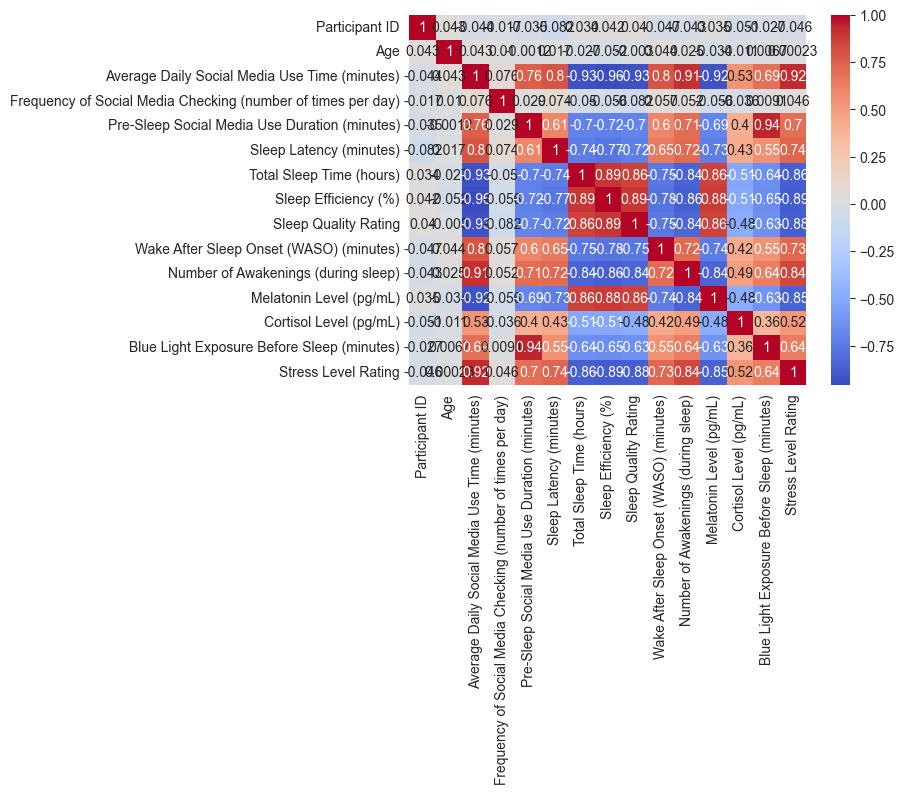

In [41]:
df_numeric = df.select_dtypes(include=[np.number])
sns.heatmap(df_numeric.corr(), cmap='coolwarm', annot=True)
plt.show()


# Feature selection & pre‑processing

In [42]:
selected_cols = [
    'Average Daily Social Media Use Time (minutes)',
    'Frequency of Social Media Checking (number of times per day)',
    'Pre-Sleep Social Media Use Duration (minutes)',
    'Dominant Social Media Platform',
    'Type of Social Media Content Consumed',
]
target_col = 'Stress Level Rating'

X = pd.get_dummies(df[selected_cols], drop_first=True)
y = df[target_col]

num_cols = [
    'Average Daily Social Media Use Time (minutes)',
    'Frequency of Social Media Checking (number of times per day)',
    'Pre-Sleep Social Media Use Duration (minutes)',
]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)


# Build models

In [44]:
lin = LinearRegression()

ridge = RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5)  # searches for the best α on a grid and picks the one that minimises cross-validated error

rf = RandomForestRegressor(n_estimators=300, random_state=42)


In [45]:
lin.fit(X_train, y_train)
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, random_state=42)

In [46]:
y_pred_lin = lin.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_rf = rf.predict(X_test)


In [47]:
def evaluate(y_true, y_pred, name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{name:<15s}  MAE: {mae:.3f}   RMSE: {rmse:.3f}   R²: {r2:.3f}')
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

print('\n--- Test‑set performance ---')
evaluate(y_test, y_pred_lin, 'Linear Regression')
evaluate(y_test, y_pred_ridge, 'Ridge Regression')
evaluate(y_test, y_pred_rf, 'Random Forest')

print(f"\nRidge alpha used: {ridge.alpha_:.4f}")


--- Test‑set performance ---
Linear Regression  MAE: 0.408   RMSE: 0.499   R²: 0.810
Ridge Regression  MAE: 0.407   RMSE: 0.497   R²: 0.811
Random Forest    MAE: 0.361   RMSE: 0.465   R²: 0.834

Ridge alpha used: 3.1623


C:\Users\tarok\AppData\Local\Temp\ipykernel_24316\3593627565.py:8: UserWarning:

Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.

C:\Users\tarok\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.



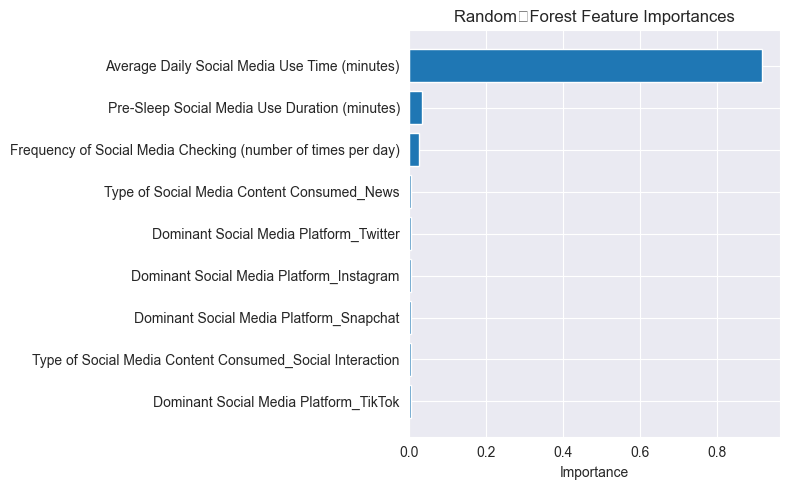

In [48]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values()

plt.figure(figsize=(8, 5))
plt.barh(feat_imp.index, feat_imp.values)
plt.xlabel('Importance')
plt.title('Random‑Forest Feature Importances')
plt.tight_layout()
plt.show()
